In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz 

!pip install pydot

import pydot
from IPython.core.display import Image 


In [6]:
data = pd.read_csv("/content/drive/MyDrive/DSL/[정규세션 220208] Decision Tree/diabetes.csv")

In [38]:
data.shape
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [39]:
X = data.iloc[:,:-1]
Y = data['Outcome']

In [40]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [49]:
print(X_train.shape)
print(X_test.shape)

(576, 8)
(192, 8)


* 트리 생성

In [50]:
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

#강의에서 나온 함수 사용하겠습니다.

In [66]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [67]:
draw_decision_tree(clf, feature_names = X.columns, class_names = ['Normal','diabetes'])
#심하게 복잡함.

Output hidden; open in https://colab.research.google.com to view.

In [68]:
pred = clf.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred)
print('예측 정확도 {0:.4f}'.format(accuracy))

예측 정확도 0.7396


* 가지치기

In [70]:
from sklearn.model_selection import GridSearchCV

hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=clf, param_grid=hyperparamters, cv=5, verbose=1)

GridCV.fit(X_train, y_train)
GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 4, 'min_samples_split': 2}

In [71]:
print('사전 가지치기 예측 정확도 {0:.4f}'.format(GridCV.best_score_)) #살짝 상승했다.

사전 가지치기 예측 정확도 0.7308


In [72]:
clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [73]:
clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf, X.columns, ['Normal','diabetes']))
    clfs.append(clf)
    print("====================================================================================")

Output hidden; open in https://colab.research.google.com to view.

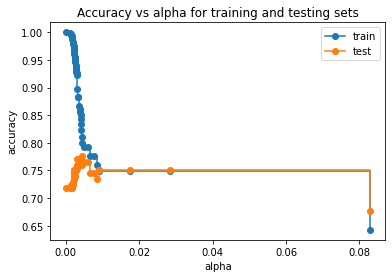

Decision tree with the best pruning : 21 nodes, 0.776 accuracy


In [75]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

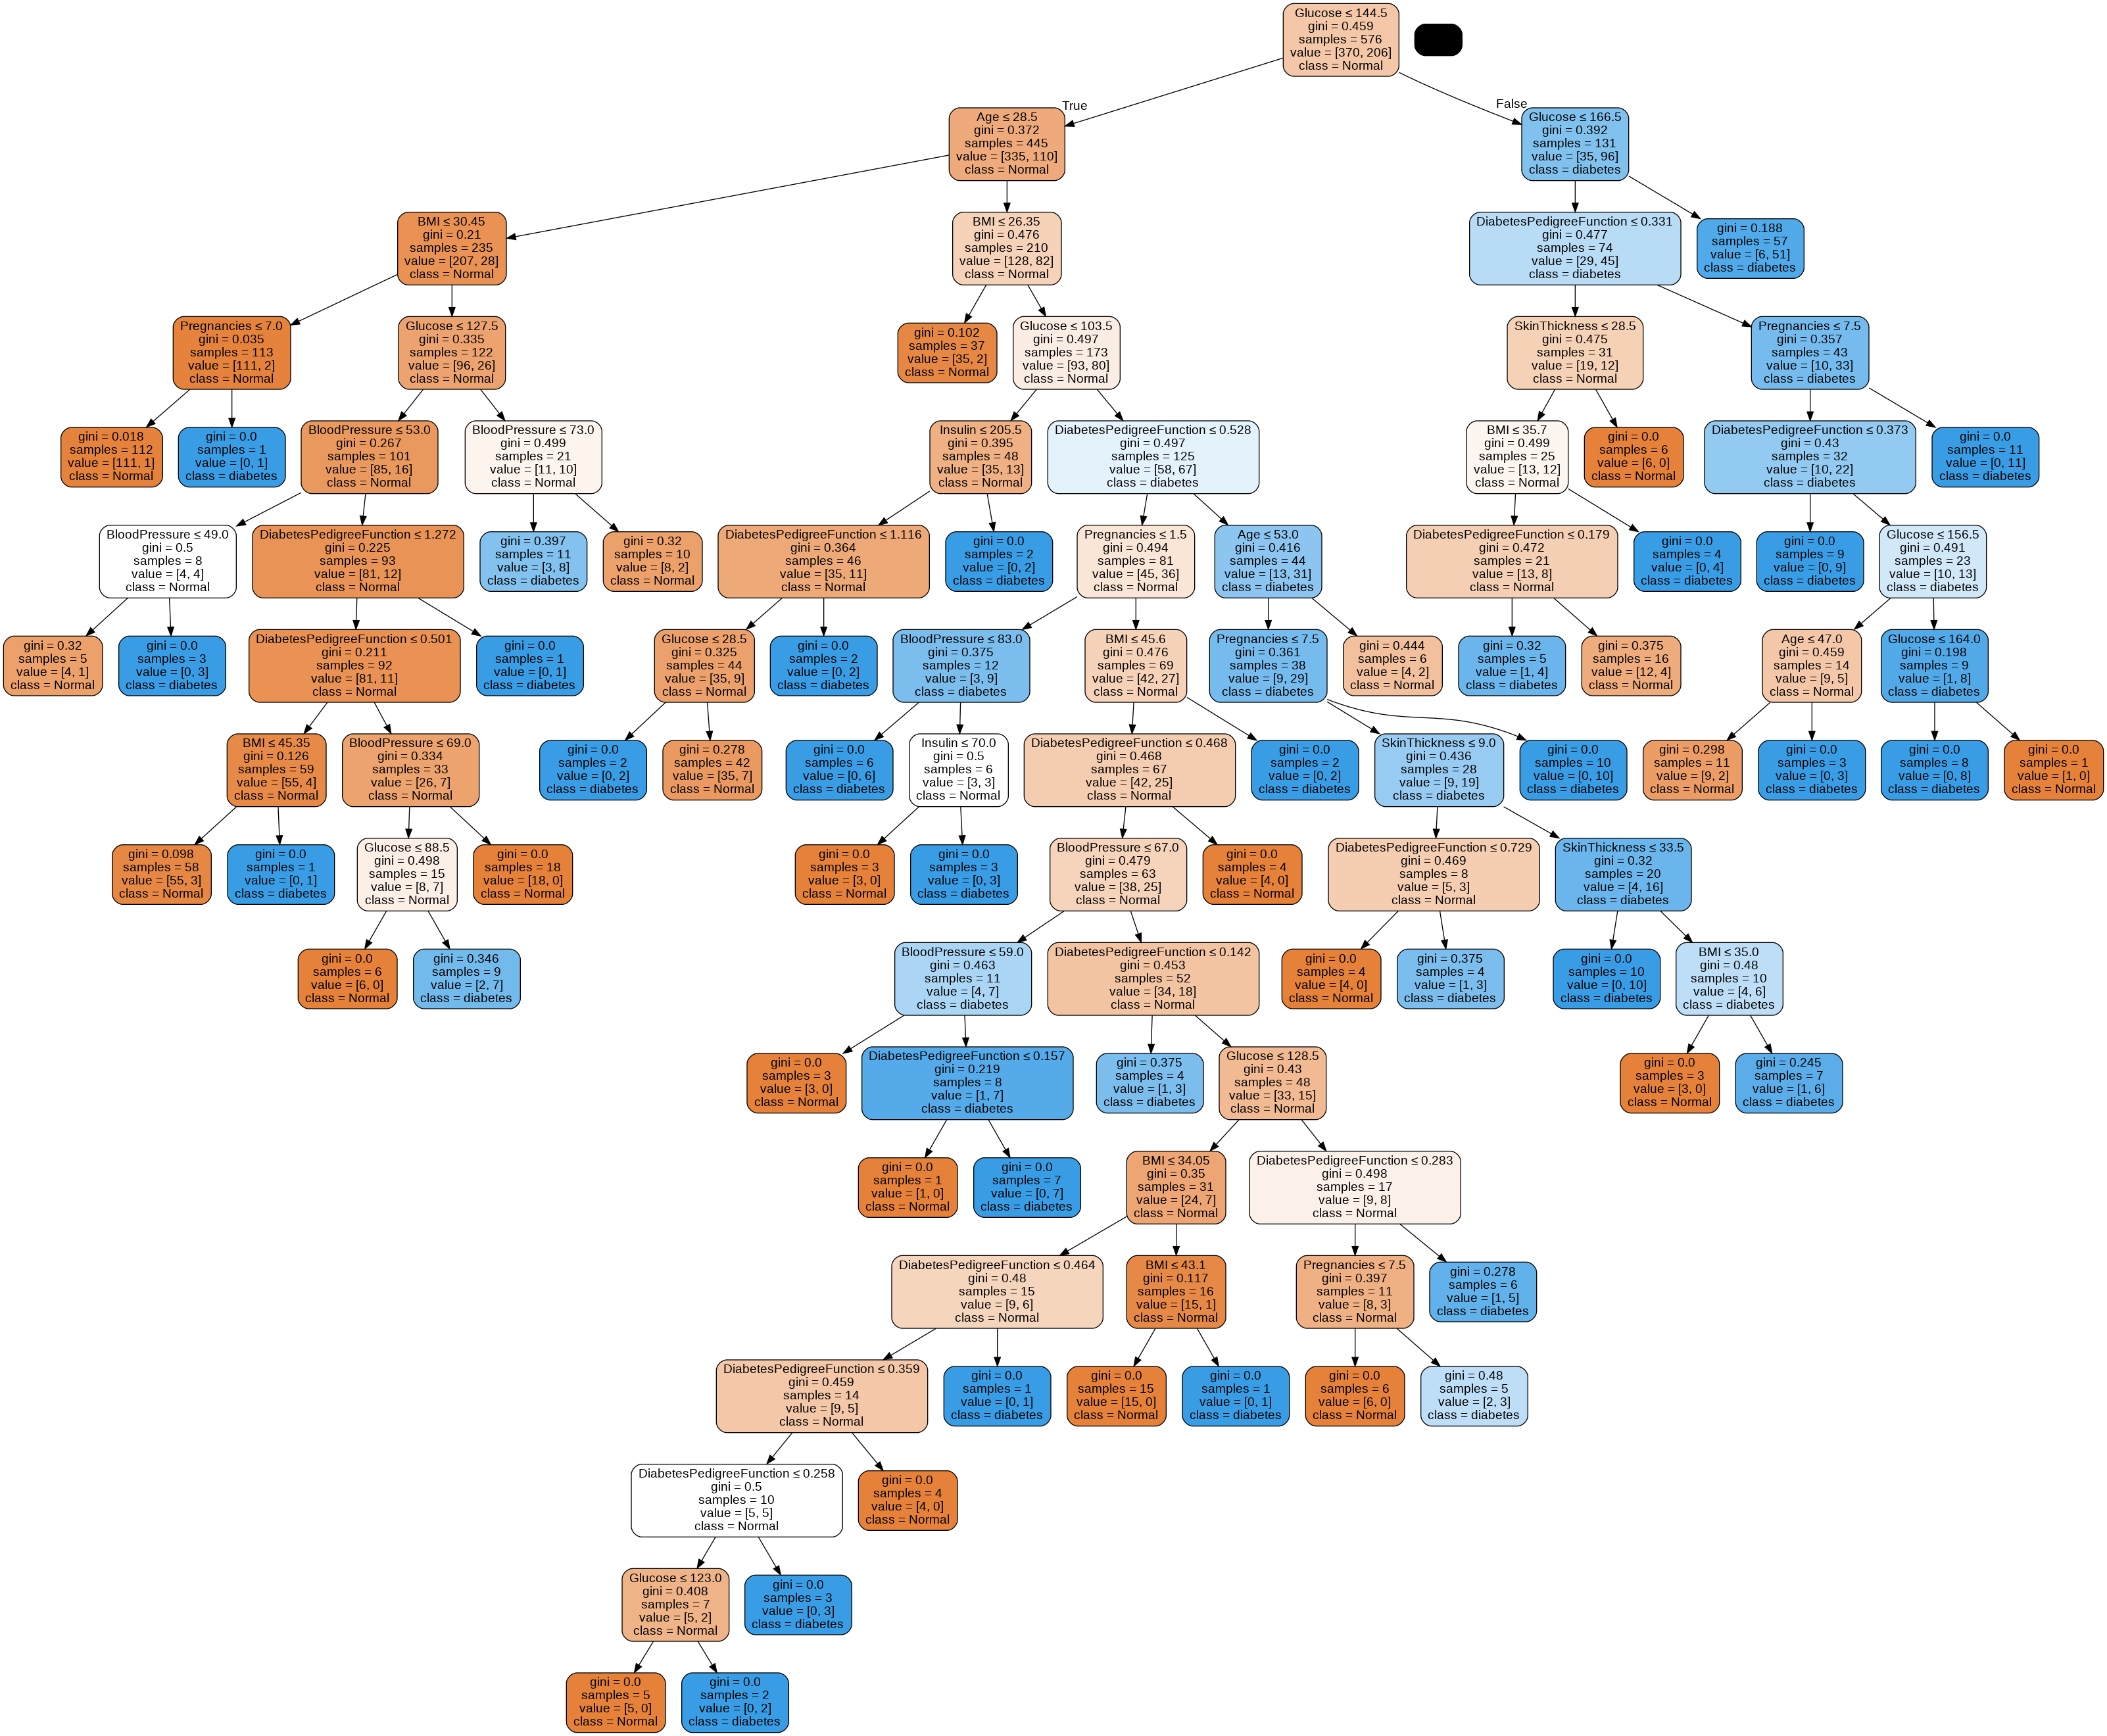

In [76]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.003)
clf = clf.fit(X_train, y_train)
draw_decision_tree(clf, X.columns, ['Normal','diabetes'])